# ASL Classification with Deep Learning

## Install Vortex

In [1]:
!rm -rf vortex
!git clone https://github.com/nodefluxio/vortex.git
!cd vortex && git checkout drop-enforce && pip install --ignore-installed --timeout=10000 ./src/development
!cd vortex && pip install --ignore-installed --timeout=10000 ./src/runtime[onnxruntime]
!pip install torchtext==0.7
!pip install onnxruntime-gpu==1.7.0
!pip install -q kaggle
!pip install split-folders
!pip install comet-ml
!rm -rf vortex

Cloning into 'vortex'...
remote: Enumerating objects: 5252, done.
remote: Counting objects: 100% (289/289), done.
remote: Compressing objects: 100% (211/211), done.
remote: Total 5252 (delta 105), reused 164 (delta 62), pack-reused 4963
Receiving objects: 100% (5252/5252), 17.17 MiB | 23.63 MiB/s, done.
Resolving deltas: 100% (3084/3084), done.
Branch 'drop-enforce' set up to track remote branch 'drop-enforce' from 'origin'.
Switched to a new branch 'drop-enforce'
Processing ./src/development
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 20.3 MB 33.1 MB/s 
     |████████████████████████████████| 28.2 MB

In [2]:
!mkdir -p plot

In [1]:
import comet_ml
from comet_ml import Experiment
from pytorch_lightning.loggers import CometLogger
import splitfolders
from google.colab import files

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as vision
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy

from collections import OrderedDict
from abc import abstractmethod

from vortex.development.utils.registry import Registry
from vortex.development.utils.metrics import METRICS, ClassificationMetrics, MetricBase
from vortex.development.networks.models import ModelBase
from vortex.development.utils.profiler.lightning import Profiler
from vortex.development.exporter.onnx import ONNXExporter
from vortex.development.utils.runtime_wrapper import RuntimeWrapper

## Data Preparation

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kriswiliant0","key":"ee5639be0e3047f07d5a184b81492ddd"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [26]:
!kaggle datasets download -d lcastrillon/mini-asl-alphabet
!kaggle datasets download -d danrasband/asl-alphabet-test
!kaggle datasets download -d grassknoted/asl-alphabet

mini-asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)
asl-alphabet-test.zip: Skipping, found more recently modified local copy (use --force to force download)
100% 1.02G/1.03G [00:09<00:00, 134MB/s]
100% 1.03G/1.03G [00:09<00:00, 121MB/s]


In [7]:
! unzip /content/mini-asl-alphabet.zip -d Dataset
! unzip /content/asl-alphabet-test.zip -d Dataset2

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/mini_asl_alphabet/asl_alphabet_train/Z/Z71.jpg  
  inflating: Dataset/mini_asl_alphabet/asl_alphabet_train/Z/Z72.jpg  
  inflating: Dataset/mini_asl_alphabet/asl_alphabet_train/Z/Z73.jpg  
  inflating: Dataset/mini_asl_alphabet/asl_alphabet_train/Z/Z74.jpg  
  inflating: Dataset/mini_asl_alphabet/asl_alphabet_train/Z/Z75.jpg  
  inflating: Dataset/mini_asl_alphabet/asl_alphabet_train/Z/Z76.jpg  
  inflating: Dataset/mini_asl_alphabet/asl_alphabet_train/Z/Z77.jpg  
  inflating: Dataset/mini_asl_alphabet/asl_alphabet_train/Z/Z78.jpg  
  inflating: Dataset/mini_asl_alphabet/asl_alphabet_train/Z/Z79.jpg  
  inflating: Dataset/mini_asl_alphabet/asl_alphabet_train/Z/Z8.jpg  
  inflating: Dataset/mini_asl_alphabet/asl_alphabet_train/Z/Z80.jpg  
  inflating: Dataset/mini_asl_alphabet/asl_alphabet_train/Z/Z81.jpg  
  inflating: Dataset/mini_asl_alphabet/asl_alphabet_train/Z/Z82.jpg  
  inflating: Dataset/mini_asl_alphabet/a

In [27]:
! unzip /content/asl-alphabet.zip -d BigDataset

Streaming output truncated to the last 5000 lines.
  inflating: BigDataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: BigDataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: BigDataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: BigDataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: BigDataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: BigDataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: BigDataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: BigDataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: BigDataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: BigDataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: BigDataset/asl_alphabet_train/asl_alphabet_train/nothing/no

## Data Pre-process

In [36]:
class ASL(pl.LightningDataModule):
    def __init__(self, batch_size, **kwargs):
        super().__init__()
        self.batch_size = batch_size
        self.val_ratio = 0.2
        self._init_dataset()
    
    def prepare_data(self):
        pass
    
    def _init_dataset(self):
        train_transform = vision.transforms.Compose([
              vision.transforms.Resize((224, 224)),
              vision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
              vision.transforms.RandomRotation(18),
              vision.transforms.ToTensor(),
              vision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
          ])
        
        test_transform = vision.transforms.Compose([
              vision.transforms.Resize((224, 224)), 
              vision.transforms.ToTensor(),
              vision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        splitfolders.ratio('/content/BigDataset/asl_alphabet_train/asl_alphabet_train', output="Train2-Val2", ratio = (0.80,0.20))
        self.train_set = vision.datasets.ImageFolder('/content/Train2-Val2/train', transform=train_transform)
        self.val_set = vision.datasets.ImageFolder('/content/Train2-Val2/val', transform=test_transform)
        self.test_set = vision.datasets.ImageFolder('/content/Dataset2', transform=test_transform)
        self.class_names = self.train_set.classes

    def train_dataloader(self):
        kwargs = dict(
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )
        self.train_loader = torch.utils.data.DataLoader(self.train_set, **kwargs)
        return self.train_loader
    
    def val_dataloader(self):
        kwargs = dict(
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )
        self.val_loader = torch.utils.data.DataLoader(self.val_set, **kwargs)
        return self.val_loader

    def test_dataloader(self):
        kwargs = dict(
              batch_size=self.batch_size,
              shuffle=False,
              num_workers=2
          )
        self.test_loader = torch.utils.data.DataLoader(self.test_set, **kwargs)
        return self.test_loader

## Model Preparation

In [37]:
class Model(ModelBase):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.criterion = nn.NLLLoss()
        self.metrics = ClassificationMetrics()
        self.basemodel = vision.models.resnet50(pretrained=True)
        self.freeze()
        self.basemodel.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes),
            nn.LogSoftmax(dim=1)                    
        )

    def postprocess(self, x):
        x = torch.nn.functional.softmax(x, dim=1)
        conf_label, cls_label = x.max(dim=1, keepdim=True)
        return torch.stack((cls_label.float(), conf_label), dim=1)

    def predict(self, x):
        x = self.basemodel(x)
        return self.postprocess(x)

    def forward(self, x):
        x = self.basemodel(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self.basemodel(x)
        loss = self.criterion(preds, y)
        acc = accuracy(preds, y)
        prediction = self.postprocess(preds)
        self.log('train_loss', loss, on_step=True, on_epoch=True,
                 prog_bar=True, logger=True)
        self.metrics.update(prediction.cpu().detach(), y.cpu().detach())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        with torch.no_grad():
            preds = self.basemodel(x)
            loss = self.criterion(preds, y)
            acc = accuracy(preds, y)
            prediction = self.postprocess(preds)
            self.log('val_loss', loss, on_step=True, on_epoch=True,
                    prog_bar=True, logger=True)
            self.log('val_acc', accuracy(preds, y), on_step=True,
                     on_epoch=True, prog_bar=True, logger=True)
            self.metrics.update(prediction.cpu().detach(), y.cpu().detach())

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.basemodel.parameters(), lr=0.001)
        return optimizer
    
    def validation_step_end(self, validation_step_outputs):
        self.log_dict(self.metrics.compute(), on_epoch=True,
                      prog_bar=True, logger=True)
    
    def validation_epoch_end(self, *args, **kwargs):
        # we know that ClassificationMetrics' state need to be reset
        self.metrics.eval_init()

    def training_epoch_end(self, outs):
        # log epoch metric
        self.log_dict(self.metrics.compute())
        # we know that ClassificationMetrics' state need to be reset
        self.metrics.eval_init()

    def freeze(self):
        for param in self.basemodel.parameters():
            param.requires_grad = False # Freezing Weight
    
    def unfreeze(self):
        for param in self.basemodel.parameters():
            param.requires_grad = True # Unfreezing Weight

    def get_example_inputs(self):
        return self.sample,

    @property
    def input_names(self):
        return self._input_names

    @property
    def output_names(self):
        return self._output_names

    def on_export_start(self, exporter, dataset=None):
        batch_size = exporter.batch_size
        # not mandatory
        self.sample = next(iter(dataset.train_dataloader()))[0]
        self.sample = self.sample[:batch_size]
        self.class_names   = dataset.class_names
        self._input_names  = ['input']
        self._output_names = ['output']

    @property
    def input_names(self):
        return self._input_names

    @property
    def output_names(self):
        return self._output_names

    def on_export_start(self, exporter, dataset=None):
        batch_size = exporter.batch_size
        # not mandatory
        self.sample = next(iter(dataset.train_dataloader()))[0]
        self.sample = self.sample[:batch_size]
        self.class_names   = dataset.class_names
        self._input_names  = ['input']
        self._output_names = ['output']

    @property
    def available_metrics(self):
        return self.metrics

    @property
    def output_format(self):
        return {
            "class_label": {"indices": [0], "axis": 0},
            "class_confidence": {"indices": [1], "axis": 0}
        }

## Prepare Utilities

In [38]:
from pytorch_lightning.callbacks import EarlyStopping

# Create Callbacks
callbacks = [
    EarlyStopping(monitor='val_acc_epoch', patience=3, verbose=True)
]

EarlyStopping mode set to max for monitoring val_acc_epoch.
INFO:lightning:EarlyStopping mode set to max for monitoring val_acc_epoch.


In [39]:
comet_logger = CometLogger(
    api_key="zbgid8jPuVj8xnllphyYycs4p",
    project_name="asl-classification-final",
    workspace="zogojogo",
)

CometLogger will be initialized in online mode
INFO:lightning:CometLogger will be initialized in online mode


In [40]:
export_path = 'export_test2.onnx'

## Train & Evaluate Model

In [41]:
def train():
    dataset = ASL(64)
    loggers = [
        comet_logger,
        pl.loggers.TensorBoardLogger('logs/'),
    ]
    trainer = pl.Trainer(
        max_epochs=4, gpus=-1, logger=loggers, callbacks=callbacks
    )
    model = Model(29)
    model.unfreeze()
    trainer.fit(model, dataset)

    exporter = ONNXExporter(dataset=dataset)
    exporter(model, export_path)

In [42]:
def evaluate():
  dataset = ASL(1)
  profiler = Profiler(plot_dir='plot')
  trainer = pl.Trainer(profiler=profiler)
  metric_args = dict(num_classes=29)
  model = RuntimeWrapper(export_path, profiler=profiler,
                         metric_args=metric_args,
                         runtime='cuda')
  batch_size=model.batch_size
  test_loader = dataset.test_dataloader()
  trainer.test(model, test_loader)
  print(profiler.summary())

  if isinstance(profiler, Profiler):
    md = profiler.report(model=model, experiment_name='ASL')

In [43]:
train()

Copying files: 87000 files [00:34, 2523.12 files/s]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning:

You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/zogojogo/asl-classification-final/0ec4c134486f4c6d8db38d518153ddb4


  | Name      | Type                  | Params
----------------------------------------------------
0 | criterion | NLLLoss         

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/zogojogo/asl-classification-final/0ec4c134486f4c6d8db38d518153ddb4
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [4]                : (0.9241066575050354, 0.9832413793103448)
COMET INFO:     f1_score (macro) [4]        : (0.9236084818840027, 0.983239527049548)
COMET INFO:     f1_score (micro) [4]        : (0.9241066575050354, 0.9832413793103448)
COMET INFO:     f1_score (weighted) [4]     : (0.9240978360176086, 0.9832395270495482)
COMET INFO:     loss [438]                  : (0.0023600116837769747, 3.3787693977355957)
COMET INFO:     precision (macro) [4]       : (0.9

Copying files: 87000 files [00:34, 2527.11 files/s]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning:

You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.

GPU available: True, used: False
INFO:lightning:GPU available: True, used: False
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning:

GPU available but not used. Set the --gpus flag when calling the script.



Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.20172413793103447,
 'f1_score (macro)': 0.2397305491467439,
 'f1_score (micro)': 0.20172413793103447,
 'f1_score (weighted)': 0.13905116723011443,
 'precision (macro)': 0.25661005770371953,
 'precision (micro)': 0.20172413793103447,
 'precision (weighted)': 0.3741086505364067,
 'recall (macro)': 0.3749808429118774,
 'recall (micro)': 0.20172413793103447,
 'recall (weighted)': 0.20172413793103447}
--------------------------------------------------------------------------------
on_fit_start : 2.2411346435546875e-05 (mean); 2.2411346435546875e-05 (median);
cache_result : 1.4508365786552246e-05 (mean); 1.0728836059570312e-05 (median);
run_test_evaluation : 37.6813805103302 (mean); 37.6813805103302 (median);
on_test_start : 0.07067513465881348 (mean); 0.07067513465881348 (median);
on_test_epoch_start : 3.6716461181640625e-05 (mean); 3.6716461181640625e-05 (median);
on_te

FileNotFoundError: ignored

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

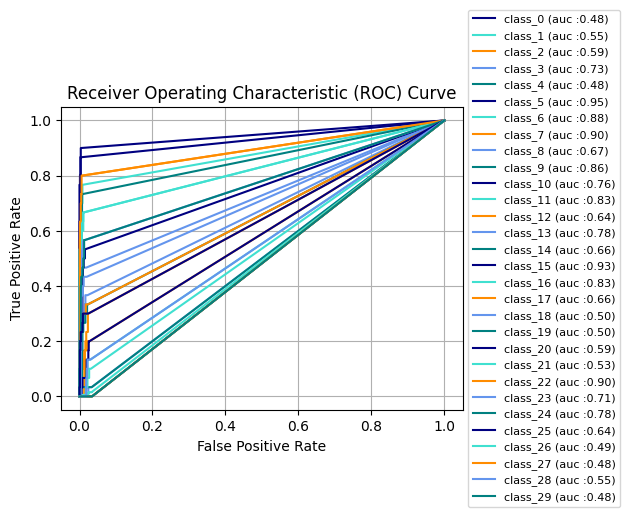

In [44]:
evaluate()

## Save & Export Model

In [ ]:
model = Model(2)
torch.save(model.state_dict(), 'my_model')
comet_logger.experiment.log_model('model_0', './my_model')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/export_test.onnx '/content/drive/MyDrive/Studs/Saved Model Nodeflux'
!cp /content/ASL.png '/content/drive/MyDrive/Studs/Saved Model Nodeflux'
!cp /content/ASL_pr_curve.png '/content/drive/MyDrive/Studs/Saved Model Nodeflux'
!cp /content/export_test.onnx '/content/drive/MyDrive/Studs/Saved Model Nodeflux'

In [ ]:
!curl -L "https://public.roboflow.com/ds/tLuuT05Xz8?key=3Jmp6HBYZ2" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip